In [2]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import pycatch22 as catch22
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer, LabelEncoder
from metric_learn import MMC_Supervised
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from collections import defaultdict
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from pysindy.feature_library import CustomLibrary, GeneralizedLibrary, TensoredLibrary
from sklearn.metrics import log_loss

In [3]:
class featureSpace:
    def __init__(self):
        self.rs = None # fitted robust scaler
        self.mm = None # fitted minMax scaler
        self.calDataNorm = None # normalized calibration data
        self.calDataTS = None # time series calibration data
        self.testDataNorm = None # normalized projected data
        self.testDataTS = None # time series projected data
        self.epsilon = None # tolerance threshold 
        self.learnedMetric = None # metric function learned from calibration data
        self.pca_calibrated = None # low dimensional embedding of the calibrated space
        self.sig = FunctionTransformer(self.sigmoid, kw_args={'theta': 1.35})
        self.pca_fit = None
        self.epsilon = 1 # optimal threshold
    
    @staticmethod
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))

    def fit(self, cal_samples, cal_ts):
        """Normalize the calibration data"""
        self.calDataTs = cal_ts
        self.rs = RobustScaler().fit(cal_samples.iloc[:,:22])
        rs_transformed = self.rs.transform(cal_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        self.mm = MinMaxScaler().fit(sig_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.calDataNorm = pd.DataFrame(mm_transformed)
        self.calDataNorm['N'] = cal_samples['N'].values
        self.calDataNorm['eta'] = cal_samples['eta'].values
        self.calDataNorm['mu'] = cal_samples['mu'].values
        self.calDataNorm['model'] = cal_samples['model'].values
        self.pca_fit = PCA(n_components=2).fit(self.calDataNorm.iloc[:,:22])
    
    # function to evaluate the trained space using new data - to be used with external eval function which
    # feeds in new training data, test data and the log/loss + accuracy is returned for each iteration of a loop
    def evaluate(self, test_samples, test_ts, radii):
        """Evaluate the calibrated space on new data
        Args:
            test_samples (pd.DataFrame): new data to be evaluated
            test_ts (pd.DataFrame): time series data for new data
            radii (list): list of radii to be evaluated
        Returns:
            (pd.DataFrame): dataframe containing the log loss and accuracy for each radius
            Predicted probabilities for each sample for each radius
            """
        self.testDataTS = test_ts
        rs_transformed = self.rs.transform(test_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.testDataNorm = pd.DataFrame(mm_transformed)
        self.testDataNorm['N'] = test_samples['N'].values
        self.testDataNorm['eta'] = test_samples['eta'].values
        self.testDataNorm['mu'] = test_samples['mu'].values
        self.testDataNorm['model'] = test_samples['model'].values
        
        # fit ABC radius Classifier and evaluate
        acc = list()
        predicted_proba = list() # list of predicted probabilities for each test sample
        logloss_vals = list()
        for r in radii:
            abc = RadiusNeighborsClassifier(radius=r, outlier_label='most_frequent')
            abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
            y_pred = abc.predict_proba(self.testDataNorm.iloc[:,:22])
            predicted_proba.append(y_pred)
            logloss_vals.append(log_loss(self.testDataNorm['model'], y_pred))
            acc.append(abc.score(self.testDataNorm.iloc[:,:22], self.testDataNorm['model']))
        results = pd.DataFrame({'radius': radii, 'accuracy': acc, 'logloss': logloss_vals})
        return results, predicted_proba

    # function to compute the distributions of pairwise distances within and between classes in the calibrated space
    #def pairwiseDist(self, showPlot = True):


    def predict(self, proj_samples, proj_ts, showPlot=False): # project new data into the calibrated space
        self.projDataTS = proj_ts
        rs_transformed = self.rs.transform(proj_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.projDataNorm = pd.DataFrame(mm_transformed)
        self.projDataNorm['N'] = proj_samples['N'].values
        self.projDataNorm['eta'] = proj_samples['eta'].values
        self.projDataNorm['mu'] = proj_samples['mu'].values
        self.projDataNorm['model'] = proj_samples['model'].values
        # project new data into calibrated space
        #predicted_proba = list()
        abc = RadiusNeighborsClassifier(radius=self.epsilon, outlier_label='most_frequent')
        abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
        y_pred = abc.predict_proba(self.projDataNorm.iloc[:,:22])

        if showPlot:
            fig = plt.figure(figsize=(8,5))
            plt.ylabel('P(M|D)', fontsize=15)
            plt.xlabel('Model', fontsize=15)
            models = abc.classes_
            plt.title(f"True = {proj_samples['model'].values[0]}, Predicted = {abc.predict(self.projDataNorm.iloc[:,:22])[0]}, $\epsilon = {self.epsilon}$", fontsize=15)
            sns.barplot(x=models, y=y_pred[0])
            plt.show()
        
        return [y_pred, abc.predict(self.projDataNorm.iloc[:,:22]), abc.classes_]


    def pcaViz(self, return_df = False): # generalize to other projection technqiues
        """Visualize the calibrated space in 2D using PCA"""
        pca_calibrated = self.pca_fit.transform(self.calDataNorm.iloc[:,:22])
        plt.figure(figsize=(12,8))
        plt.title('Unoptimised Space, PCA')
        sns.scatterplot(x=pca_calibrated[:,0], y=pca_calibrated[:,1], hue=self.calDataNorm['model'], s=3 )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()
        if return_df:
            pca_calibrated = pd.DataFrame(pca_calibrated).rename(columns={0:'PC1', 1:'PC2'})
            pca_calibrated['N'] = self.calDataNorm['N']
            pca_calibrated['eta'] = self.calDataNorm['eta']
            pca_calibrated['mu'] = self.calDataNorm['mu']
            pca_calibrated['model'] = self.calDataNorm['model']
            return pca_calibrated

    def getDistances(self):
        features = self.calDataNorm.iloc[:, 0:22]
        classes = self.calDataNorm['model']

        # Split the dataset into different classes
        class_data = defaultdict(list)
        for idx, row in df.iterrows():
            class_data[row['model']].append(row[:22].values)

        # Calculate pairwise distances within each class
        intra_class_distances = {}
        for class_label, feature_vectors in class_data.items():
            intra_class_distances[class_label] = pairwise_distances(feature_vectors)

        # Calculate pairwise distances between different classes
        inter_class_distances = defaultdict(dict)
        for class_label_1, feature_vectors_1 in class_data.items():
            for class_label_2, feature_vectors_2 in class_data.items():
                if class_label_1 != class_label_2:
                    inter_class_distances[class_label_1][class_label_2] = pairwise_distances(feature_vectors_1, feature_vectors_2)

        return intra_class_distances, inter_class_distances
        
    def setEpsilon(self, epsilon):
        """Manually set the tolerance threshold"""
        self.epsilon = epsilon

In [4]:
class LogMap:
    def __init__(self):
        self.mu = None
        self.model = 'LogMap'
        self.transients = 1000
        # store sampling range
        self.mu_min = 2.5
        self.mu_max = 3.95
    
    def set_mu(self, mu):
        self.mu = mu
    
    # generate from deterministic logmap with measurement noise
    def generate_deterministic(self, N, eta_measurement):
        x = np.zeros((N+self.transients, 2))
        x[0] = [np.random.uniform(low=0, high=0.5), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = self.mu * x[i-1, 0] * (1-x[i-1, 0])
            x[i, 1] = self.mu

        # add measurement noise
        noise = np.zeros((N, 2))
        noise[:, 0] = eta_measurement * np.random.randn(N)

        return x[self.transients:] + noise
    
    # generate from logmap with intrinsic process noise (and measurement noise)
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
        x = np.zeros((N+self.transients, 2))
        x[0] = [np.random.uniform(low=0, high=0.5), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = np.maximum(np.minimum(self.mu * x[i-1, 0] * (1 - x[i - 1, 0]) + eta_intrinsic * np.random.randn(), 1), 0)
            x[i, 1] = self.mu
        
        # add measurement noise if specified
        if eta_measurement:
            noise = np.zeros((N, 2))
            noise[:, 0] = eta_measurement * np.random.randn(N)
            return x[self.transients:] + noise
        else:
            return x[self.transients:]

class HenonMap:
    def __init__(self):
        self.mu = None
        self.model = 'HenonMap'
        self.transients = 1000
        self.b = 0.3
        # store sampling range
        self.mu_min = 0.1
        self.mu_max = 1.0
    
    def set_mu(self, mu):
        self.mu = mu

    # generate data such that it is also compatible with SINDy
    def generate_deterministic(self, N, eta_measurement):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = 1 - self.mu * x[i-1, 0]**2 + x[i-1, 1]
            x[i, 1] = self.b * x[i-1, 0] 
            x[i, 2] = self.mu

        # add measurement noise
        noise = np.zeros((N, 3))
        noise[:, :2] = eta_measurement * np.random.randn(N,2)

        return x[self.transients:] + noise
    
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = 1 - self.mu * x[i-1, 0]**2 + x[i-1, 1] + eta_intrinsic * np.random.randn()
            x[i, 1] = self.b * x[i-1, 0] + eta_intrinsic * np.random.randn()
            x[i, 2] = self.mu
        
        # add measurement noise
        if eta_measurement:
            noise = np.zeros((N, 3))
            noise[:, :2] = eta_measurement * np.random.randn(N)
            return x[self.transients:] + noise
        else:
            return x[self.transients:]

class BurgersMap:
    def __init__(self):
        self.mu = None
        self.model = 'BurgersMap'
        self.transients = 1000
        self.a = 0.75
        # store sampling range
        self.mu_min = 0.9
        self.mu_max = 1.8

    def set_mu(self, mu):
        self.mu = mu
    
    # generate data such that it is also compatible with SINDy
    def generate_deterministic(self, N, eta_measurement):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = self.a * x[i-1, 0] - x[i-1,1]**2 
            x[i, 1] = self.mu * x[i-1, 1] + x[i-1, 0] * x[i-1, 1]
            x[i, 2] = self.mu
        
        # add measurement noise
        noise = np.zeros((N, 3))
        noise[:, :2] = eta_measurement * np.random.randn(N,2)
        return x[self.transients:] + noise
    
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = self.a * x[i-1, 0] - x[i-1,1]**2 + eta_intrinsic * np.random.randn()
            x[i, 1] = self.mu * x[i-1, 1] + x[i-1, 0] * x[i-1, 1] + eta_intrinsic * np.random.randn()
            x[i, 2] = self.mu
        
        # add measurement noise
        if eta_measurement:
            noise = np.zeros((N, 3))
            noise[:, :2] = eta_measurement * np.random.randn(N,2)
            return x[self.transients:] + noise
        else:
            return x[self.transients:]

class CubicMap:
    def __init__(self):
        self.mu = None
        self.model = 'CubicMap'
        self.transients = 1000
        # store sampling range
        self.mu_min = 1.8
        self.mu_max = 3.0
    
    def set_mu(self, mu):
        self.mu = mu

    # generate data such that it is also compatible with SINDy
    def generate_deterministic(self, N, eta_measurement):
            x = np.zeros((N + self.transients, 2))
            x[0] = [np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  self.mu * x[i-1, 0] * (1-x[i-1, 0]**2)
                x[i, 1] =  self.mu
            
            # add measurement noise
            noise = np.zeros((N, 1))
            noise[:, 0] = eta_measurement * np.random.randn(N)
            return x[self.transients:] + noise
    
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
            x = np.zeros((N + self.transients, 2))
            x[0] = [np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  self.mu * x[i-1, 0] * (1-x[i-1, 0]**2) + eta_intrinsic * np.random.randn()
                x[i, 1] =  self.mu
            
            # add measurement noise
            if eta_measurement:
                noise = np.zeros((N, 1))
                noise[:, 0] = eta_measurement * np.random.randn(N)
                return x[self.transients:] + noise
            else:
               return x[self.transients:] 
         
class TinkerBellMap:
    # https://www.mdpi.com/2076-3417/8/12/2640
    def __init__(self):
        self.mu = None
        self.model = 'TinkerBellMap'
        self.transients = 1000
        self.mu_min = 0.1 # here mu (critical param is arbitrarily set to c as per Sprott's definition)
        self.mu_max = 1.6
        self.a = 0.9
        self.b = -0.6013
        self.d = 0.5 
    
    def set_mu(self, mu):
        self.mu = mu

    def generate_deterministic(self, N, eta_measurement):
            x = np.zeros((N + self.transients, 3))
            x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1]
                x[i, 1] =  2 * x[i-1, 0] * x[i-1, 1] + self.mu * x[i-1, 0] + self.d * x[i-1, 1]
                x[i, 2] =  self.mu
            
            # add measurement noise
            noise = np.zeros((N, 3))
            noise[:, :2] = eta_measurement * np.random.randn(N,2)
            return x[self.transients:] + noise

    # generate data such that it is also compatible with SINDy
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
            x = np.zeros((N + self.transients, 3))
            x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1] + eta_intrinsic * np.random.randn()
                x[i, 1] =  2 * x[i-1, 0] * x[i-1, 1] + self.mu * x[i-1, 0] + self.d * x[i-1, 1] + eta_intrinsic * np.random.randn()
                x[i, 2] =  self.mu
            
            # add measurement noise
            if eta_measurement:
                noise = np.zeros((N, 3))
                noise[:, :2] = eta_measurement * np.random.randn(N,2)
                return x[self.transients:] + noise
            else:
                return x[self.transients:]
    
         

In [5]:
def generate_LogMap(N_val, eta_val):
    # generate samples from a particular map for comparison between methods
    # return sols list (ts) for SINDy and df for our method
    mus = [2.5, 2.75, 3, 3.25, 3.5, 3.75, 3.8, 3.85, 3.9, 3.95] # mu windows to sample from - taken from SINDy paper
    sols_list = list()
    for mu in mus:
        x = LogMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['LogMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_HenonMap(N_val, eta_val):
    # generate samples from a particular map for comparison between methods
    # return sols list (ts) for SINDy and df for our method
    mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
    sols_list = list()
    for mu in mus:
        x = HenonMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['HenonMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_BurgersMap(N_val, eta_val, seed=None):
    mus = [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.65, 1.7]
    sols_list = list()
    for mu in mus:
        x = BurgersMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['BurgersMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_CubicMap(N_val, eta_val, seed=None):
    mus = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7]
    sols_list = list()
    for mu in mus:
        x = CubicMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['CubicMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_TinkerBellMap(N_val, eta_val, seed=None):
    mus = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    sols_list = list()
    for mu in mus:
        x = TinkerBellMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['TinkerBellMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_SineMap(N_val, eta_val, seed=None):
    mus = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
    sols_list = list()
    for mu in mus:
        x = SineMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['SineMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts


In [6]:
def sample_maps(num_samples, N_val=None, eta_val=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    models = [LogMap(), HenonMap(), BurgersMap(), TinkerBellMap(), CubicMap()]
    sel_model = list()
    lengths = list()
    mus = list()
    etas = list()
    sols = list()
    for i in range(num_samples):
        model = np.random.choice(models) # pick a model
        sel_model.append(model)
        mu = np.random.uniform(low=model.mu_min, high=model.mu_max) # pick a mu
        mus.append(mu)
        if N_val is None:
            N = np.random.randint(low=50, high=10000)
        else:
            N = N_val
        lengths.append(N)
        if eta_val is None:
            eta = np.random.uniform(low=0., high=0.2) # pick a noise level
        else:
            eta = eta_val
        etas.append(eta)
        model.set_mu(mu)
        sol = model.generate_deterministic(N, eta)
        sols.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols[i][:,0])['values'] for i in range(len(sols))])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['mu'] = mus
    df['eta'] = etas
    df['model'] = [sel_model[i].model for i in range(len(sel_model))]
    ts = sols
    return df, ts


In [7]:
def is_within_tolerance(ground_truth, obtained_value, tolerance=0.1):
    # tolerance is a percentage ie. 0.1 = 10%
    lower_bound = np.abs(ground_truth) * (1 - tolerance)
    upper_bound = np.abs(ground_truth) * (1 + tolerance)

    return lower_bound <= np.abs(obtained_value) <= upper_bound

In [8]:
def evaluate_space(model, num_iter, cal_data_length, test_data_length, showPlot=True):
    meta_acc = list()
    meta_logloss = list()
    radii = np.linspace(0.1, 10, 20)
    for i in range(num_iter):
        print(f'iteration: {i}')
        # generate calibration data 
        df_cal, ts_cal = sample_maps(cal_data_length)
        df_cal = df_cal.dropna()
        print(len(df_cal))
        # generate test data
        df_test, ts_test = sample_maps(test_data_length) 
        df_test = df_test.dropna()
        print(len(df_test))
        # train the space
        model.fit(df_cal, ts_cal)
        df_eval, predicted_proba = space.evaluate(df_test, ts_test, radii)
        meta_acc.append(df_eval['accuracy'].values)
        meta_logloss.append(df_eval['logloss'].values)
    
    optimal_epsilon_ll = radii[np.argmin(np.mean(meta_logloss, axis=0))]
    print(f'Optimal Epsilon (LogLoss): {optimal_epsilon_ll}')
    
    if showPlot:
        fig, ax = plt.subplots(1,2, figsize=(22,8))
        ax[0].errorbar(radii, np.mean(meta_acc, axis=0), yerr=np.std(meta_acc, axis=0), label='std', capsize=3)
        ax[0].axvline(x=radii[np.argmax(np.mean(meta_acc, axis=0))], c='r', linestyle='--', label='optimal threshold')
        ax[0].set_xlabel('$\epsilon$')
        ax[0].set_ylabel('Accuracy')

        ax[1].errorbar(radii, np.mean(meta_logloss, axis=0), yerr=np.std(meta_logloss, axis=0), label='std', capsize=3)
        ax[1].axvline(x=radii[np.argmin(np.mean(meta_logloss, axis=0))], c='r', linestyle='--', label='optimal threshold')
        ax[1].set_xlabel('$\epsilon$')
        ax[1].set_ylabel('Log Loss')
        plt.show()
    

In [9]:
def isLogMap_sindy(test_ts, model, tol=0.1, showEq=False):
    # tol 0.1 = 10% of the ground truth

    model.fit(test_ts, multiple_trajectories=True, quiet=True)
    if showEq:
        model.print()
    coeffs = model.coefficients()
    x_coeffs, mu_coeffs = coeffs[0], coeffs[1]

    non_zero_idx_x, non_zero_idx_mu = np.nonzero(x_coeffs)[0], np.nonzero(mu_coeffs)[0]

    expected_non_zero_idx_x = {4: 1.0, 7: -1.0}
    expected_non_zero_idx_mu = {2: 1.0}

    if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_mu) == list(expected_non_zero_idx_mu.keys()):
        valid_coeffs = True
        for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
            if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                valid_coeffs = False
                break
        for idx, ground_truth_coeff in expected_non_zero_idx_mu.items():
            if not is_within_tolerance(ground_truth_coeff, mu_coeffs[idx], tol):
                valid_coeffs = False
                break

        if valid_coeffs:
            return True

    return False

In [10]:
def isHenonMap_sindy(test_ts, model, tol=0.1, showEq=False):
    # strict criteria -> must have 2 non-zero coefficients for x and 1 non-zero coefficient for mu
    # non-strict criteria -> can more (unexpected) coefficients as long as they are within the tolerance

    model.fit(test_ts, multiple_trajectories=True, quiet=True)
    if showEq:
        model.print()
    coeffs = model.coefficients()
    x_coeffs, y_coeffs = coeffs[0], coeffs[1]

    non_zero_idx_x, non_zero_idx_y = np.nonzero(x_coeffs)[0], np.nonzero(y_coeffs)[0]

    expected_non_zero_idx_x = {0: 1.0, 2: 1.0, 12: -1.0}
    expected_non_zero_idx_y = {1: 0.3}

    if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_y) == list(expected_non_zero_idx_y.keys()):
        valid_coeffs = True
        for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
            if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                valid_coeffs = False
                break
        for idx, ground_truth_coeff in expected_non_zero_idx_y.items():
            if not is_within_tolerance(ground_truth_coeff, y_coeffs[idx], tol):
                valid_coeffs = False
                break
        if valid_coeffs:
            return True

    return False

        

In [11]:
def isBurgersMap_sindy(test_ts, model, tol=0.1, showEq=False):
    # strict criteria -> must have 2 non-zero coefficients for x and 1 non-zero coefficient for mu
    # non-strict criteria -> can more (unexpected) coefficients as long as they are within the tolerance


   
    model.fit(test_ts, multiple_trajectories=True, quiet=True)
    if showEq:
        model.print()
    coeffs = model.coefficients()
    x_coeffs, y_coeffs = coeffs[0], coeffs[1]

    non_zero_idx_x, non_zero_idx_y = np.nonzero(x_coeffs)[0], np.nonzero(y_coeffs)[0]


    expected_non_zero_idx_x = {1: 0.75, 7: -1.0}
    expected_non_zero_idx_y = {5: 1.0, 8: 1.0}

    if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_y) == list(expected_non_zero_idx_y.keys()):
        valid_coeffs = True
        for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
            if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                print(idx, is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol))
                valid_coeffs = False
                break
        for idx, ground_truth_coeff in expected_non_zero_idx_y.items():
            if not is_within_tolerance(ground_truth_coeff, y_coeffs[idx], tol):
                valid_coeffs = False
                break
        if valid_coeffs:
            return True

    return False

In [12]:
def isCubicMap_sindy(test_ts, model, tol=0.1, showEq=False):
    # strict criteria -> must have 2 non-zero coefficients for x and 1 non-zero coefficient for mu
    # non-strict criteria -> can more (unexpected) coefficients as long as they are within the tolerance



    model.fit(test_ts, multiple_trajectories=True, quiet=True)
    if showEq:
        model.print()
    coeffs = model.coefficients()
    x_coeffs = coeffs[0]

    non_zero_idx_x = np.nonzero(x_coeffs)[0]

    expected_non_zero_idx_x = {4: 1.0, 11: -1.0}

    if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()):
        valid_coeffs = True
        for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
            if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                valid_coeffs = False
                break

        if valid_coeffs:
            return True

    return False



In [13]:
def isTinkerBellMap_sindy(test_ts, model, tol=0.1, showEq=False):
    
    model.fit(test_ts, multiple_trajectories=True, quiet=True)
    if showEq:
        model.print()
    coeffs = model.coefficients()
    x_coeffs, y_coeffs = coeffs[0], coeffs[1]

    non_zero_idx_x, non_zero_idx_y = np.nonzero(x_coeffs)[0], np.nonzero(y_coeffs)[0]

    expected_non_zero_idx_x = {1: 0.9, 2: -0.6013, 4: 1, 7: -1}
    expected_non_zero_idx_y = {2: 0.5, 5: 2, 6: 1}

    if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_y) == list(expected_non_zero_idx_y.keys()):
        valid_coeffs = True
        for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
            if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                print(idx, is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol))
                valid_coeffs = False
                break
        for idx, ground_truth_coeff in expected_non_zero_idx_y.items():
            if not is_within_tolerance(ground_truth_coeff, y_coeffs[idx], tol):
                valid_coeffs = False
                break

        if valid_coeffs:
            return True

    return False


In [14]:
def isMap_isa(space, mapName, check_df, check_ts):
    # assume space is already calibrated/fit
    probs, preds, classes = space.predict(check_df, check_ts)
    avg_probs = np.mean(probs, axis=0) # soft voting scheme
    avg_index = np.argmax(avg_probs) 
    predicted_class = classes[avg_index]
    if predicted_class == mapName:
        return True
    else:
        return False

In [131]:
def isCubicMap_isa(space, check_df, check_ts):
    probs, preds, classes = space.predict(check_df, check_ts)
    avg_probs = np.mean(probs, axis=0) # soft voting scheme
    avg_index = np.argmax(avg_probs)
    predicted_class = classes[avg_index]
    return predicted_class

# Benchmarking

Fit the instance space, with default parameters and unoptimised epsilon value

In [15]:
# setup feature space
df, ts = sample_maps(20000, seed=87)

In [16]:
unopt_space = featureSpace()
unopt_space.fit(df, ts)

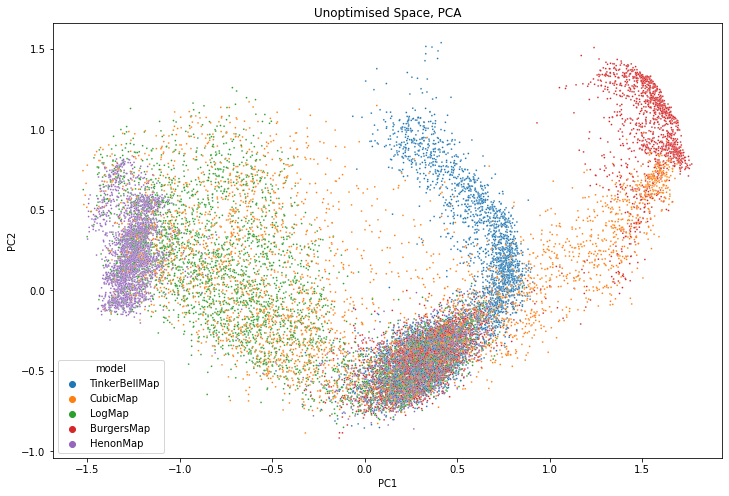

In [192]:
df_embeddings = unopt_space.pcaViz(return_df=True)

In [195]:
df_embeddings

,PC1,PC2,N,eta,mu,model
0,0.201133,-0.516040,5176,0.019566,0.510048,TinkerBellMap
1,-0.077940,-0.637702,181,0.052818,0.121316,TinkerBellMap
2,0.406842,-0.332416,156,0.125760,2.931264,CubicMap
3,0.354553,-0.364407,3019,0.157667,2.943733,LogMap
4,-0.467105,-0.115935,5748,0.188374,3.377127,LogMap
...,...,...,...,...,...,...
19995,-0.637878,0.521289,9606,0.069128,2.425507,CubicMap
19996,-0.569745,0.179480,9060,0.155017,3.644977,LogMap
19997,-1.210804,0.480263,811,0.027846,3.343833,LogMap
19998,-1.434852,0.652152,1046,0.128542,0.994172,HenonMap


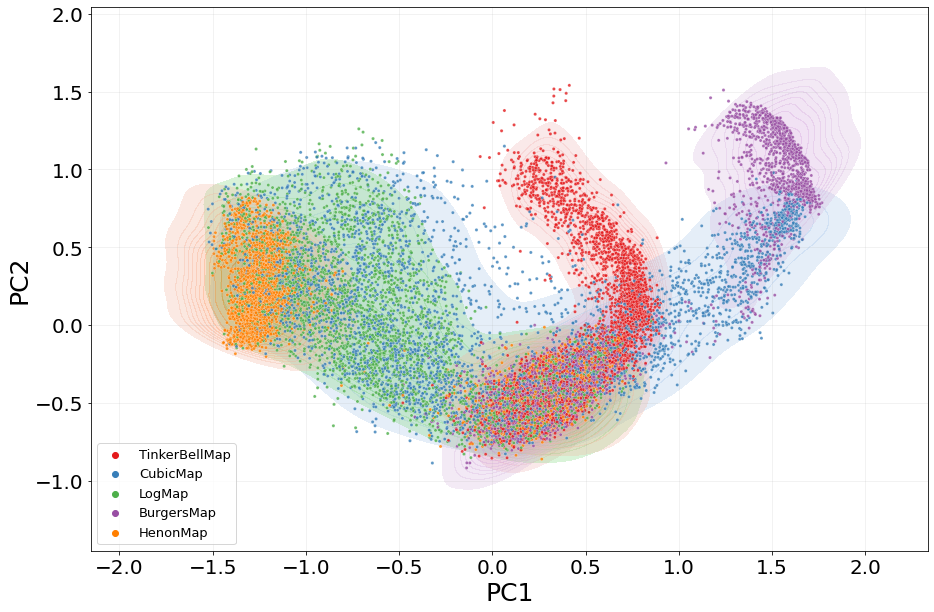

In [300]:
plt.figure(figsize=(15, 10))
sns.kdeplot(data=df_embeddings, x='PC1', y='PC2', hue='model', palette='Set1', levels=15, alpha=0.3, shade=True)
sns.scatterplot(data=df_embeddings, x='PC1', y='PC2', hue='model', palette='Set1', s=10, alpha=0.8)
plt.legend(loc='lower left', fontsize=13)
plt.xlabel('PC1', fontsize=25)
plt.ylabel('PC2', fontsize=25)
plt.grid(alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

both methods have access to the same calibration data for setting of lambda and epsilon respectively

In [18]:
def evaluate_space(space, num_iter, test_data_length, showPlot=True):
    meta_logloss = list()
    radii = np.linspace(0.1, 1.5, 50)
    for i in range(num_iter):
        print(f'iteration: {i}')
        # generate calibration data 
        df_test, ts_test = sample_maps(test_data_length) 
        df_test = df_test.dropna()
        print(len(df_test))
        df_eval, predicted_proba = space.evaluate(df_test, ts_test, radii)
        meta_logloss.append(df_eval['logloss'].values)
    
    optimal_epsilon_ll = radii[np.argmin(np.mean(meta_logloss, axis=0))]
    print(f'Optimal Epsilon (LogLoss): {optimal_epsilon_ll}')
    
    if showPlot:
        plt.figure(figsize=(15, 8))
        plt.errorbar(radii, np.mean(meta_logloss, axis=0), yerr=np.std(meta_logloss, axis=0), label='std', capsize=3)
        plt.axvline(x=radii[np.argmin(np.mean(meta_logloss, axis=0))], c='r', linestyle='--', label='optimal threshold')
        plt.xlabel('$\epsilon$')
        plt.ylabel('Log Loss')
        plt.show()
    
    return df_test, ts_test
    

iteration: 0
10000
Optimal Epsilon (LogLoss): 0.8999999999999999


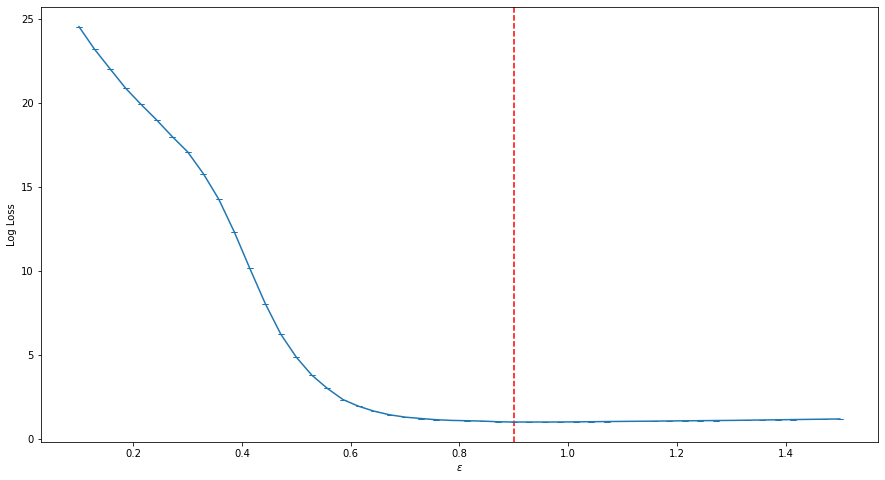

In [19]:
df_test, ts_test = evaluate_space(unopt_space, 1, 10000)

In [20]:
unopt_space.setEpsilon(0.9)

LogMap lambda: 0.05, num: 9
CubicMap lambda: 0.05, num: 0
TinkerBellMap lambda: 0.05, num: 0
HenonMap lambda: 0.05, num: 0
BurgersMap lambda: 0.05, num: 0
LogMap lambda: 0.06842105263157895, num: 31
CubicMap lambda: 0.06842105263157895, num: 4
TinkerBellMap lambda: 0.06842105263157895, num: 0
HenonMap lambda: 0.06842105263157895, num: 0
BurgersMap lambda: 0.06842105263157895, num: 0
LogMap lambda: 0.0868421052631579, num: 31
CubicMap lambda: 0.0868421052631579, num: 23
TinkerBellMap lambda: 0.0868421052631579, num: 0
HenonMap lambda: 0.0868421052631579, num: 0
BurgersMap lambda: 0.0868421052631579, num: 0
LogMap lambda: 0.10526315789473685, num: 16
CubicMap lambda: 0.10526315789473685, num: 46
TinkerBellMap lambda: 0.10526315789473685, num: 0
HenonMap lambda: 0.10526315789473685, num: 0
BurgersMap lambda: 0.10526315789473685, num: 0
LogMap lambda: 0.1236842105263158, num: 0
CubicMap lambda: 0.1236842105263158, num: 39
TinkerBellMap lambda: 0.1236842105263158, num: 0
HenonMap lambda: 0.

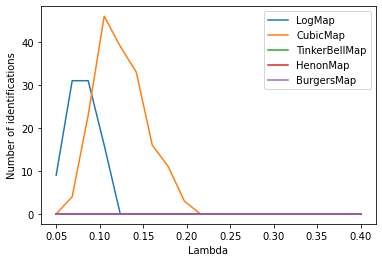

In [104]:
# Define a list of map functions and identification functions
lambdas = np.linspace(0.05, 0.4, 20)
map_functions = [generate_LogMap, generate_CubicMap, generate_TinkerBellMap, generate_HenonMap, generate_BurgersMap]
identification_functions = [isLogMap_sindy, isCubicMap_sindy, isTinkerBellMap_sindy, isHenonMap_sindy, isBurgersMap_sindy]
map_names = ['LogMap', 'CubicMap', 'TinkerBellMap', 'HenonMap', 'BurgersMap']

# Initialize a dictionary to store the results
results = {name: [] for name in map_names}

# Initialize a list to store the total number of identifications for each lambda
total_identifications = []

for lamb in lambdas:
    total_num = 0
    for map_func, ident_func, map_name in zip(map_functions, identification_functions, map_names):
        num = 0
        model = ps.SINDy(feature_library=generalised_lib, feature_names=['x', 'y', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=lamb))
        
        for N in Ns:
            for eta in etas:
                df_map, ts_map = map_func(N, eta)
                if ident_func(ts_map, model, tol=0.1):
                    num += 1
        
        results[map_name].append(num)
        total_num += num
        print(f'{map_name} lambda: {lamb}, num: {num}')
    
    total_identifications.append(total_num)

# Find the best lambda
best_lambda_idx = np.argmax(total_identifications)
best_lambda = lambdas[best_lambda_idx]
print(f'Best lambda: {best_lambda}')

# Plot the results
for map_name, num_list in results.items():
    plt.plot(lambdas, num_list, label=map_name)

plt.xlabel('Lambda')
plt.ylabel('Number of identifications')
plt.legend()
plt.show()


## SINDy V1 (Naive)

Both approaches have access to the same information for optimisation:
- Labelled training data set to optimise epsilon (our method), naive SINDy with general library

Construct a generalised candidate library for naive SINDy consisting of:
- Polynomials up to degree 5
- Trigonometric functions wih 1 frequency
- Exponential functions


In [21]:
fourier_library = ps.FourierLibrary(n_frequencies=1)
polynomial_library = ps.PolynomialLibrary(degree=5)
custom_funcs = [lambda x: np.exp(x), lambda x: np.exp(-x)]
custom_funcs_names = [lambda x: 'exp(' + x +')', lambda x: 'exp(-' + x + ')']
custom_lib = ps.CustomLibrary(library_functions=custom_funcs, function_names=custom_funcs_names)

In [22]:
generalised_lib = ps.GeneralizedLibrary([polynomial_library, fourier_library, custom_lib])

## Explore the low-data, high noise regime for Logistic Map Identification

## Unconstrained SINDy

In [232]:
Ns = [25, 50, 75, 100, 125, 150, 175, 200, 300, 400, 500, 800, 1000]  # time series lengths
etas = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.05]  # list of eta values
model = ps.SINDy(feature_library=generalised_lib, feature_names=['x', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=0.1))

n_iter = 100
results_log = dict()
results_log_isa = dict()

for eta in etas:
    n_identifications = list()
    n_identifications_isa = list()
    for n in Ns:
        identifications = list()
        identifications_isa = list()
        for i in range(n_iter):
            df_test, ts_test = generate_LogMap(n, eta)
            identifications.append(isLogMap_sindy(ts_test, model, tol=0.1))
            identifications_isa.append(isMap_isa(unopt_space, 'LogMap', df_test, ts_test))
        non_zero_sindy = np.count_nonzero(identifications)
        non_zero_isa = np.count_nonzero(identifications_isa)
        n_identifications.append(non_zero_sindy)
        n_identifications_isa.append(non_zero_isa)
    fraction_identified_sindy = np.array(n_identifications) / n_iter
    fraction_identified_isa = np.array(n_identifications_isa) / n_iter
    results_log[eta] = fraction_identified_sindy
    results_log_isa[eta] = fraction_identified_isa


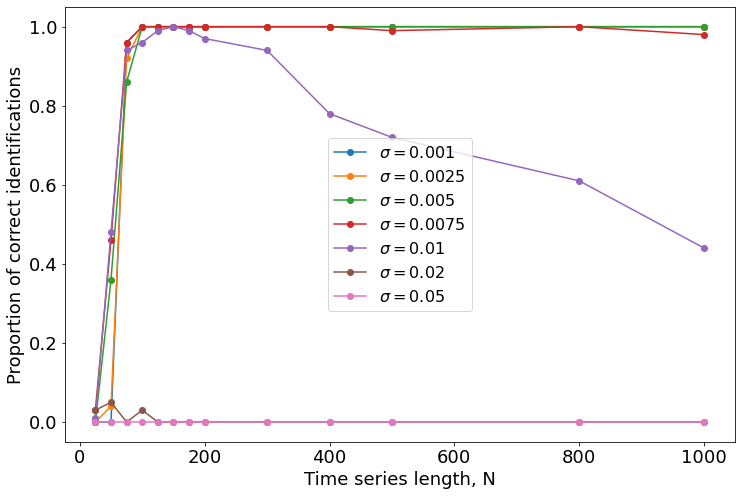

In [251]:
plt.figure(figsize=(12,8))
plt.plot(Ns, results_log[0.001], label='$\sigma = 0.001$', marker='o')
plt.plot(Ns, results_log[0.0025], label='$\sigma = 0.0025$', marker='o')
plt.plot(Ns, results_log[0.005], label='$\sigma = 0.005$', marker='o')
plt.plot(Ns, results_log[0.0075], label='$\sigma = 0.0075$', marker='o')
plt.plot(Ns, results_log[0.01], label='$\sigma = 0.01$', marker='o')
plt.plot(Ns, results_log[0.02], label='$\sigma = 0.02$', marker='o')
plt.plot(Ns, results_log[0.05], label='$\sigma = 0.05$', marker='o')
plt.xlabel('Time series length, N', fontsize=18)
plt.ylabel('Proportion of correct identifications', fontsize=18)
#plt.title('Naive SINDy Logarithmic Map Identification', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)

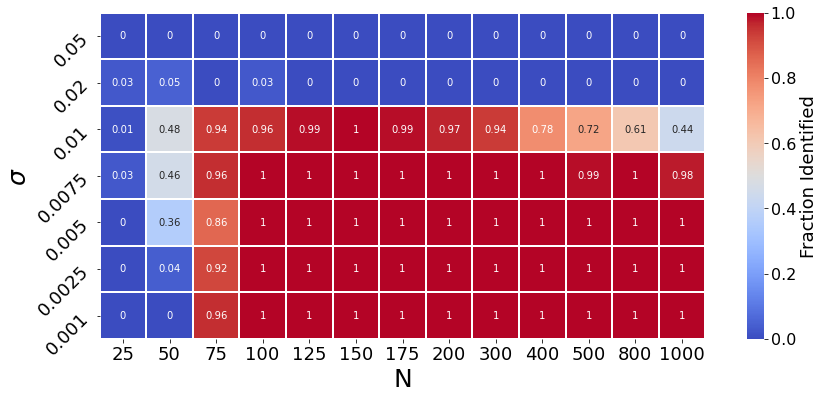

In [252]:
heatmap_data = np.array([results_log[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Fraction Identified', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

## Instance Space

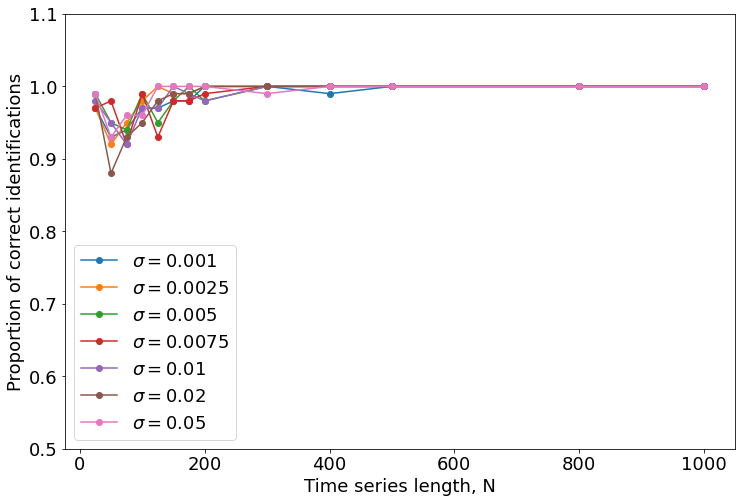

In [253]:
plt.figure(figsize=(12,8))
plt.plot(Ns, results_log_isa[0.001], label='$\sigma = 0.001$', marker='o')
plt.plot(Ns, results_log_isa[0.0025], label='$\sigma = 0.0025$', marker='o')
plt.plot(Ns, results_log_isa[0.005], label='$\sigma = 0.005$', marker='o')
plt.plot(Ns, results_log_isa[0.0075], label='$\sigma = 0.0075$', marker='o')
plt.plot(Ns, results_log_isa[0.01], label='$\sigma = 0.01$', marker='o')
plt.plot(Ns, results_log_isa[0.02], label='$\sigma = 0.02$', marker='o')
plt.plot(Ns, results_log_isa[0.05], label='$\sigma = 0.05$', marker='o')
plt.ylim(0.5, 1.1)
plt.xlabel('Time series length, N', fontsize=18)
plt.ylabel('Proportion of correct identifications', fontsize=18)
#plt.title('Naive ISA Logarithmic Map Identification', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

Plot the fraction of successfully identified instances as a heatmap

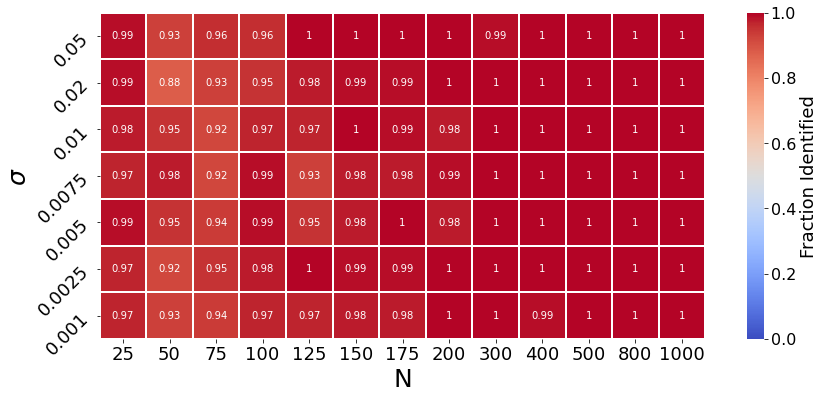

In [254]:
heatmap_data = np.array([results_log_isa[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Fraction Identified', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

## Compare the performance between both methods

To visualise the difference between SINDy and the instance space method, we will compute the difference in fraction identified and display as a single heatmap to elucidate the the strengths and weaknesses of both approaches.

In [255]:
import matplotlib.colors as mcolors

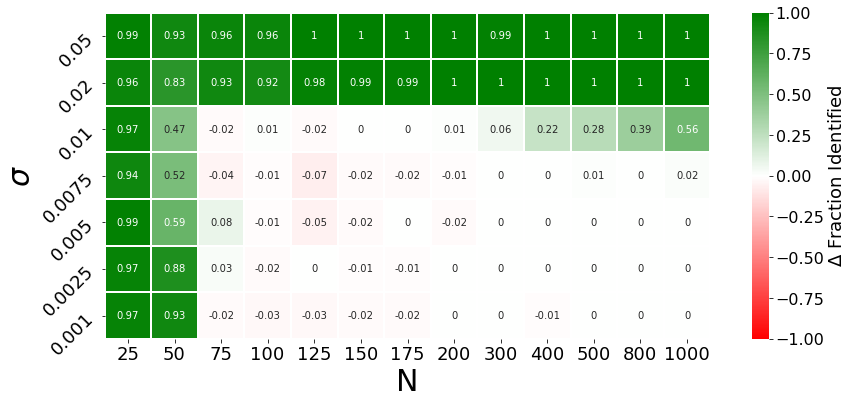

In [256]:
results_method1 = np.array([results_log[eta] for eta in etas])
results_method2 = np.array([results_log_isa[eta] for eta in etas])

# compute the difference
performance_difference = results_method2 - results_method1

colors = ['red', 'white', 'green']
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# display as a single heatmap
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(performance_difference, annot=True, cmap=cmap, xticklabels=Ns, yticklabels=etas, cbar_kws={'label': '$\Delta$ Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=-1, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('$\Delta$ Fraction Identified', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=30)
plt.ylabel('$\sigma$', fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

## Constrained SINDy

SINDy is now limited to the polynomial function basis (degree 4).

LogMap lambda: 0.05, num: 14
CubicMap lambda: 0.05, num: 47
TinkerBellMap lambda: 0.05, num: 0
HenonMap lambda: 0.05, num: 2
BurgersMap lambda: 0.05, num: 0
LogMap lambda: 0.06842105263157895, num: 49
CubicMap lambda: 0.06842105263157895, num: 62
TinkerBellMap lambda: 0.06842105263157895, num: 0
HenonMap lambda: 0.06842105263157895, num: 25
BurgersMap lambda: 0.06842105263157895, num: 0
LogMap lambda: 0.0868421052631579, num: 57
CubicMap lambda: 0.0868421052631579, num: 66
TinkerBellMap lambda: 0.0868421052631579, num: 0
HenonMap lambda: 0.0868421052631579, num: 45
BurgersMap lambda: 0.0868421052631579, num: 0
LogMap lambda: 0.10526315789473685, num: 54
CubicMap lambda: 0.10526315789473685, num: 71
TinkerBellMap lambda: 0.10526315789473685, num: 0
HenonMap lambda: 0.10526315789473685, num: 57
BurgersMap lambda: 0.10526315789473685, num: 0
LogMap lambda: 0.1236842105263158, num: 42
CubicMap lambda: 0.1236842105263158, num: 71
TinkerBellMap lambda: 0.1236842105263158, num: 0
HenonMap lam

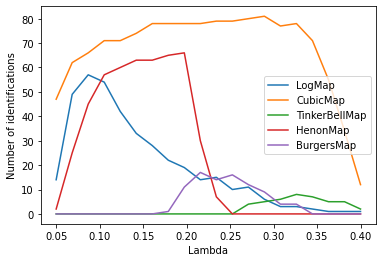

In [248]:
# Define a list of map functions and identification functions
lambdas = np.linspace(0.05, 0.4, 20)
map_functions = [generate_LogMap, generate_CubicMap, generate_TinkerBellMap, generate_HenonMap, generate_BurgersMap]
identification_functions = [isLogMap_sindy, isCubicMap_sindy, isTinkerBellMap_sindy, isHenonMap_sindy, isBurgersMap_sindy]
map_names = ['LogMap', 'CubicMap', 'TinkerBellMap', 'HenonMap', 'BurgersMap']

# Initialize a dictionary to store the results
results = {name: [] for name in map_names}

# Initialize a list to store the total number of identifications for each lambda
total_identifications = []

for lamb in lambdas:
    total_num = 0
    for map_func, ident_func, map_name in zip(map_functions, identification_functions, map_names):
        num = 0
        model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=4), feature_names=['x', 'y', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=lamb))
        
        for N in Ns:
            for eta in etas:
                df_map, ts_map = map_func(N, eta)
                if ident_func(ts_map, model, tol=0.1):
                    num += 1
        
        results[map_name].append(num)
        total_num += num
        print(f'{map_name} lambda: {lamb}, num: {num}')
    
    total_identifications.append(total_num)

# Find the best lambda
best_lambda_idx = np.argmax(total_identifications)
best_lambda = lambdas[best_lambda_idx]
print(f'Best lambda: {best_lambda}')

# Plot the results
for map_name, num_list in results.items():
    plt.plot(lambdas, num_list, label=map_name)

plt.xlabel('Lambda')
plt.ylabel('Number of identifications')
plt.legend()
plt.show()

In [250]:
model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=4), feature_names=['x', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=0.105))
Ns = [25, 50, 75, 100, 125, 150, 175, 200, 300, 400, 500, 800, 1000]  # time series lengths
etas = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.05]  # list of eta values

n_iter = 100
results_log = dict()
results_log_isa = dict()
np.random.seed(0)

for eta in etas:
    n_identifications = list()
    n_identifications_isa = list()
    for n in Ns:
        identifications = list()
        identifications_isa = list()
        for i in range(n_iter):
            df_test, ts_test = generate_LogMap(n, eta)
            identifications.append(isLogMap_sindy(ts_test, model, tol=0.1))
            identifications_isa.append(isMap_isa(unopt_space, 'LogMap', df_test, ts_test))
        non_zero_sindy = np.count_nonzero(identifications)
        non_zero_isa = np.count_nonzero(identifications_isa)
        n_identifications.append(non_zero_sindy)
        n_identifications_isa.append(non_zero_isa)
    fraction_identified_sindy = np.array(n_identifications) / n_iter
    fraction_identified_isa = np.array(n_identifications_isa) / n_iter
    results_log[eta] = fraction_identified_sindy
    results_log_isa[eta] = fraction_identified_isa


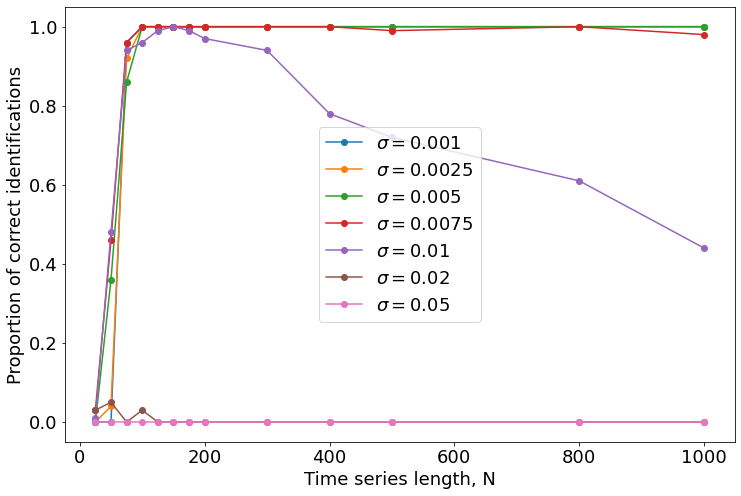

In [258]:
plt.figure(figsize=(12,8))
plt.plot(Ns, results_log[0.001], label='$\sigma = 0.001$', marker='o')
plt.plot(Ns, results_log[0.0025], label='$\sigma = 0.0025$', marker='o')
plt.plot(Ns, results_log[0.005], label='$\sigma = 0.005$', marker='o')
plt.plot(Ns, results_log[0.0075], label='$\sigma = 0.0075$', marker='o')
plt.plot(Ns, results_log[0.01], label='$\sigma = 0.01$', marker='o')
plt.plot(Ns, results_log[0.02], label='$\sigma = 0.02$', marker='o')
plt.plot(Ns, results_log[0.05], label='$\sigma = 0.05$', marker='o')
plt.xlabel('Time series length, N', fontsize=18)
plt.ylabel('Proportion of correct identifications', fontsize=18)
#plt.title('Naive SINDy Logarithmic Map Identification', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

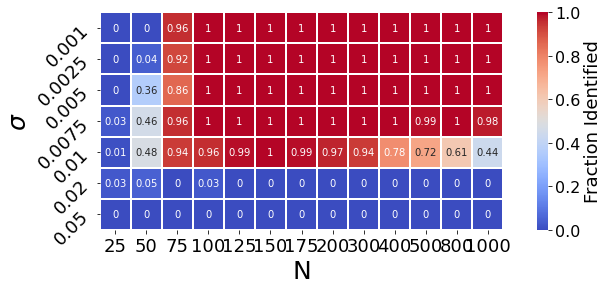

In [259]:
heatmap_data = np.array([results_log[eta] for eta in etas])
plt.figure(figsize=(12, 4))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Fraction Identified', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
plt.show()

## instance space 

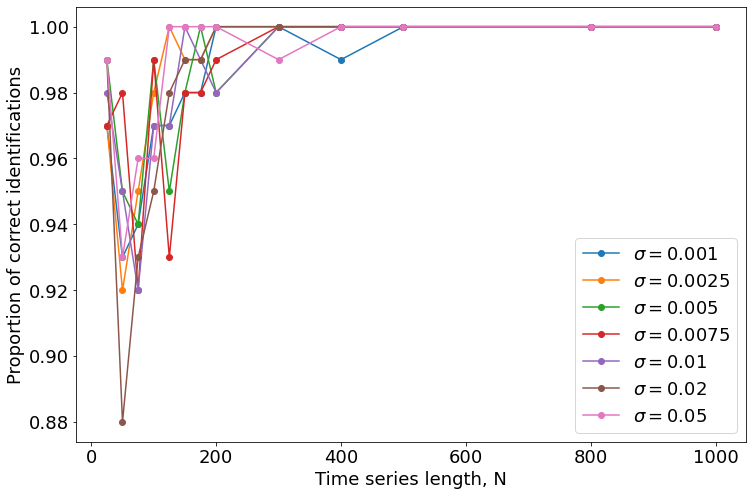

In [260]:
plt.figure(figsize=(12,8))
plt.plot(Ns, results_log_isa[0.001], label='$\sigma = 0.001$', marker='o')
plt.plot(Ns, results_log_isa[0.0025], label='$\sigma = 0.0025$', marker='o')
plt.plot(Ns, results_log_isa[0.005], label='$\sigma = 0.005$', marker='o')
plt.plot(Ns, results_log_isa[0.0075], label='$\sigma = 0.0075$', marker='o')
plt.plot(Ns, results_log_isa[0.01], label='$\sigma = 0.01$', marker='o')
plt.plot(Ns, results_log_isa[0.02], label='$\sigma = 0.02$', marker='o')
plt.plot(Ns, results_log_isa[0.05], label='$\sigma = 0.05$', marker='o')
plt.xlabel('Time series length, N', fontsize=18)
plt.ylabel('Proportion of correct identifications', fontsize=18)
#plt.title('Naive SINDy Logarithmic Map Identification', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

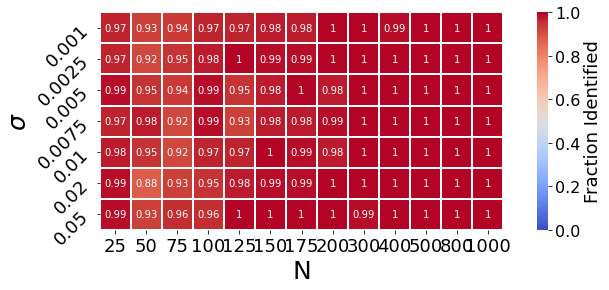

In [261]:
heatmap_data = np.array([results_log_isa[eta] for eta in etas])
plt.figure(figsize=(12, 4))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Fraction Identified', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
plt.show()

----------

## Cubic Map Identification

In [263]:
Ns = [25, 50, 85, 100, 125, 150, 175, 200, 300, 400, 500, 800, 1000]  # time series lengths
etas = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.05]  # list of eta values
model = ps.SINDy(feature_library=generalised_lib, feature_names=['x', 'mu'], discrete_time=True)

n_iter = 100
results_cubic = dict()
results_cubic_isa = dict()
np.random.seed(0)
for eta in etas:
    n_identifications = list()
    n_identifications_isa = list()
    for n in Ns:
        identifications = list()
        identifications_isa = list()
        for i in range(n_iter):
            df_test, ts_test = generate_CubicMap(n, eta)
            identifications.append(isCubicMap_sindy(ts_test, model, tol=0.1))
            identifications_isa.append(isMap_isa(unopt_space, 'CubicMap', df_test, ts_test))
        non_zero = np.count_nonzero(identifications)
        non_zero_isa = np.count_nonzero(identifications_isa)
        n_identifications.append(non_zero)
        n_identifications_isa.append(non_zero_isa)
    fraction_identified_sindy = np.array(n_identifications) / n_iter
    fraction_identified_isa = np.array(n_identifications_isa) / n_iter
    results_cubic[eta] = fraction_identified_sindy
    results_cubic_isa[eta] = fraction_identified_isa

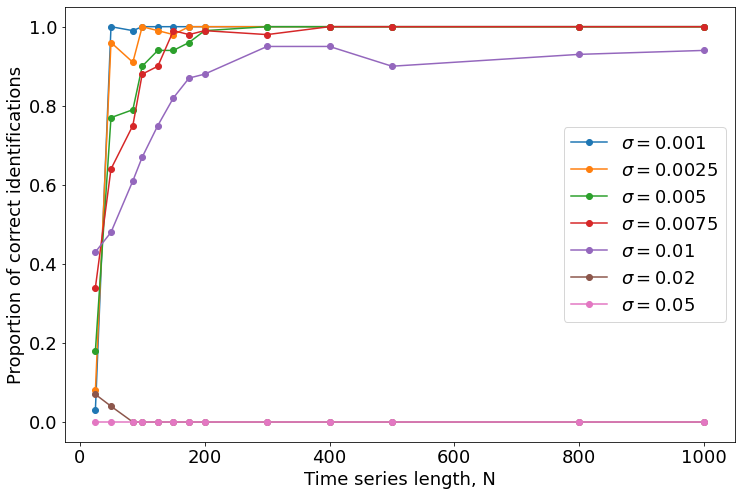

In [264]:
plt.figure(figsize=(12,8))
plt.plot(Ns, results_cubic[0.001], label='$\sigma = 0.001$', marker='o')
plt.plot(Ns, results_cubic[0.0025], label='$\sigma = 0.0025$', marker='o')
plt.plot(Ns, results_cubic[0.005], label='$\sigma = 0.005$', marker='o')
plt.plot(Ns, results_cubic[0.0075], label='$\sigma = 0.0075$', marker='o')
plt.plot(Ns, results_cubic[0.01], label='$\sigma = 0.01$', marker='o')
plt.plot(Ns, results_cubic[0.02], label='$\sigma = 0.02$', marker='o')
plt.plot(Ns, results_cubic[0.05], label='$\sigma = 0.05$', marker='o')
plt.xlabel('Time series length, N', fontsize=18)
plt.ylabel('Proportion of correct identifications', fontsize=18)
#plt.title('Naive SINDy Cubic Map Identification', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

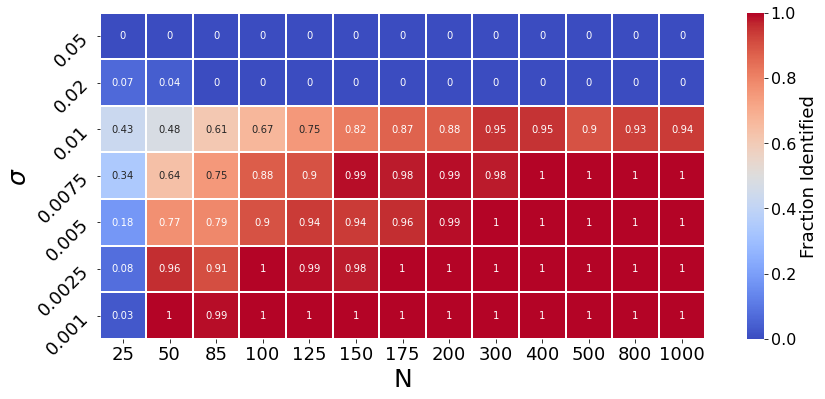

In [266]:
heatmap_data = np.array([results_cubic[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Fraction Identified', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

instance space

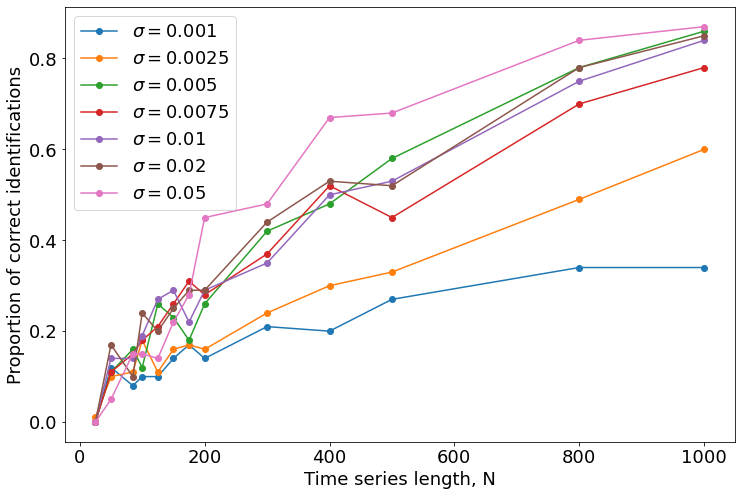

In [268]:
plt.figure(figsize=(12,8))
plt.plot(Ns, results_cubic_isa[0.001], label='$\sigma = 0.001$', marker='o')
plt.plot(Ns, results_cubic_isa[0.0025], label='$\sigma = 0.0025$', marker='o')
plt.plot(Ns, results_cubic_isa[0.005], label='$\sigma = 0.005$', marker='o')
plt.plot(Ns, results_cubic_isa[0.0075], label='$\sigma = 0.0075$', marker='o')
plt.plot(Ns, results_cubic_isa[0.01], label='$\sigma = 0.01$', marker='o')
plt.plot(Ns, results_cubic_isa[0.02], label='$\sigma = 0.02$', marker='o')
plt.plot(Ns, results_cubic_isa[0.05], label='$\sigma = 0.05$', marker='o')
plt.xlabel('Time series length, N', fontsize=18)
plt.ylabel('Proportion of correct identifications', fontsize=18)
#plt.title('Naive SINDy Cubic Map Identification', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

Poor performance int he low-data, high noise regime due to confusion between logistic map and cubic map. However, the number of successful identification increases with time series length. 

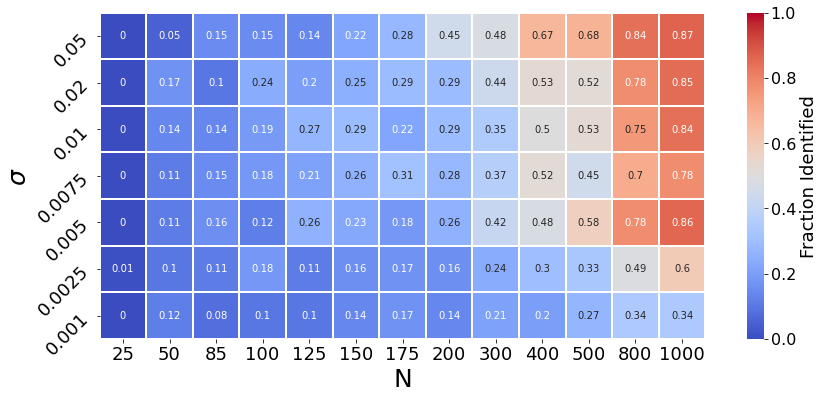

In [269]:
heatmap_data = np.array([results_cubic_isa[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Fraction Identified', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

## Difference between both methods

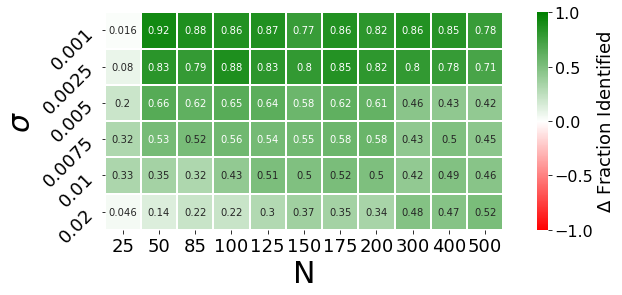

In [281]:
results_method1 = np.array([results_cubic[eta] for eta in etas])
results_method2 = np.array([results_cubic_isa[eta] for eta in etas])

# compute the difference
performance_difference = np.abs(results_method1 - results_method2)

colors = ['red', 'white', 'green']
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# display as a single heatmap
plt.figure(figsize=(12, 4))
heatmap = sns.heatmap(performance_difference, annot=True, cmap=cmap, xticklabels=Ns, yticklabels=etas, cbar_kws={'label': '$\Delta$ Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=-1, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('$\Delta$ Fraction Identified', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=30)
plt.ylabel('$\sigma$', fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
plt.show()

----------

## Henon Map

Now we consider a two-dimensional system, the Henon map. 

In [182]:
Ns = [25, 50, 85, 100, 125, 150, 175, 200, 300, 400, 500, 800, 1000]  # time series lengths
etas = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02]  # list of eta values
model = ps.SINDy(feature_library=generalised_lib, feature_names=['x', 'y', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=0.1))

n_iter = 100
results_henon = dict()
results_henon_isa = dict()

for eta in etas:
    n_identifications_sindy = list()
    n_identifications_isa = list()
    for n in Ns:
        identifications = list()
        identifications_isa = list()
        for i in range(n_iter):
            df_test, ts_test = generate_HenonMap(n, eta)
            identifications.append(isHenonMap_sindy(ts_test, model, tol=0.1))
            identifications_isa.append(isMap_isa(unopt_space, 'HenonMap', df_test, ts_test))
        non_zero_sindy = np.count_nonzero(identifications)
        non_zero_isa = np.count_nonzero(identifications_isa)
        n_identifications_sindy.append(non_zero_sindy)
        n_identifications_isa.append(non_zero_isa)
    fraction_identified_sindy = np.array(n_identifications_sindy) / n_iter
    fraction_identified_isa = np.array(n_identifications_isa) / n_iter
    results_henon[eta] = fraction_identified_sindy
    results_henon_isa[eta] = fraction_identified_isa

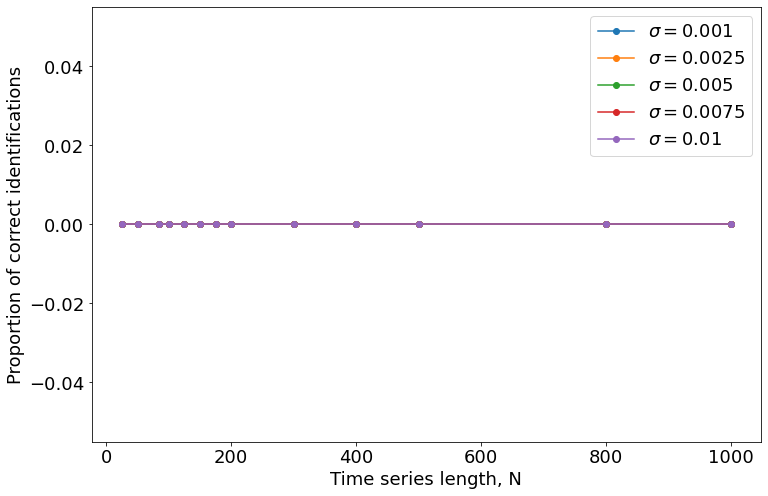

In [183]:
plt.figure(figsize=(12,8))
plt.plot(Ns, results_henon[0.001], label='$\sigma = 0.001$', marker='o')
plt.plot(Ns, results_henon[0.0025], label='$\sigma = 0.0025$', marker='o')
plt.plot(Ns, results_henon[0.005], label='$\sigma = 0.005$', marker='o')
plt.plot(Ns, results_henon[0.0075], label='$\sigma = 0.0075$', marker='o')
plt.plot(Ns, results_henon[0.01], label='$\sigma = 0.01$', marker='o')
plt.xlabel('Time series length, N', fontsize=18)
plt.ylabel('Proportion of correct identifications', fontsize=18)
#plt.title('Naive SINDy Henon Map Identification', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

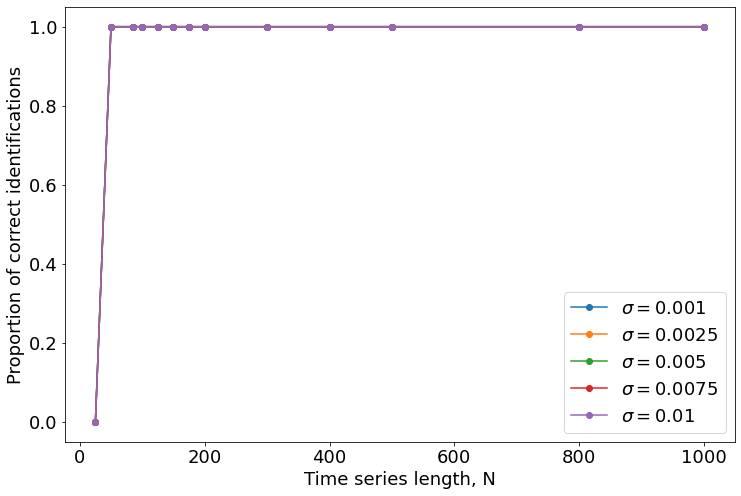

In [185]:
plt.figure(figsize=(12,8))
plt.plot(Ns, results_henon_isa[0.001], label='$\sigma = 0.001$', marker='o')
plt.plot(Ns, results_henon_isa[0.0025], label='$\sigma = 0.0025$', marker='o')
plt.plot(Ns, results_henon_isa[0.005], label='$\sigma = 0.005$', marker='o')
plt.plot(Ns, results_henon_isa[0.0075], label='$\sigma = 0.0075$', marker='o')
plt.plot(Ns, results_henon_isa[0.01], label='$\sigma = 0.01$', marker='o')
plt.xlabel('Time series length, N', fontsize=18)
plt.ylabel('Proportion of correct identifications', fontsize=18)
#plt.title('Naive SINDy Henon Map Identification', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

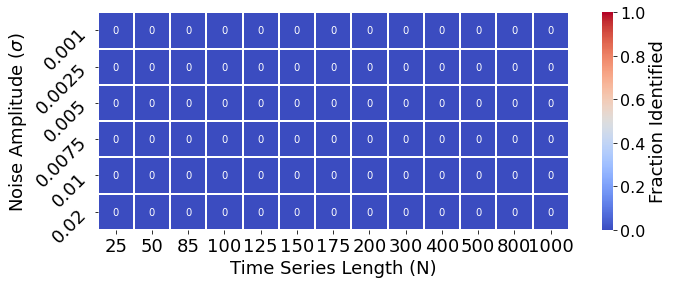

In [186]:
heatmap_data = np.array([results_henon[eta] for eta in etas])
plt.figure(figsize=(12, 4))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Fraction Identified', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('Time Series Length (N)', fontsize=18)
plt.ylabel('Noise Amplitude ($\sigma$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
plt.show()

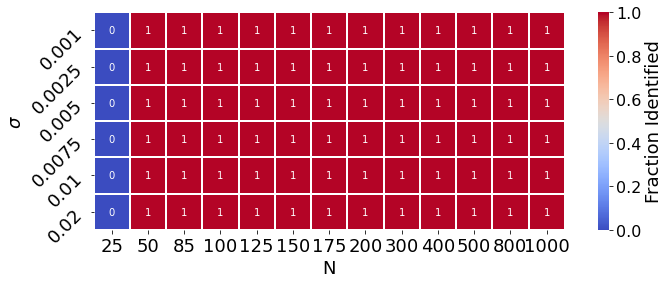

In [187]:
heatmap_data = np.array([results_henon_isa[eta] for eta in etas])
plt.figure(figsize=(12, 4))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Fraction Identified', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=18)
plt.ylabel('$\sigma$', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
plt.show()

In [16]:
df = pd.read_pickle('training_data.pkl')